<a href="https://colab.research.google.com/github/ReAlex1902/COVID_19_bot/blob/master/MRI_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Downloading dataset:
from zipfile import ZipFile

# # The below code is ran in google colab
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"  # username from the json file
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"  # key from the json file
# !kaggle datasets download -d praveengovi/coronahack-chest-xraydataset  # api copied from kaggle

# Create a ZipFile Object and load chest-xray-pneumonia.zip in it
PATH = '/content/lgg-mri-segmentation.zip'
with ZipFile(PATH, "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

#Creating DataFrame

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
PATH = '/content/lgg-mri-segmentation/kaggle_3m/'

dirnames = []
paths = []
i = 0
for sub_dir in os.listdir(PATH):
    folder = os.path.join(PATH, sub_dir)
    if os.path.isdir(folder):
        for filename in os.listdir(folder):
            image = os.path.join(folder, filename)
            dirnames.append(sub_dir)
            paths.append(image)
    else:
        print(f'{sub_dir} is not a directory')

data.csv is not a directory
README.md is not a directory


In [ ]:
data = pd.DataFrame({'folder': dirnames, 'path': paths})
data.head()

,folder,path
0,TCGA_HT_A61B_19991127,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
1,TCGA_HT_A61B_19991127,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
2,TCGA_HT_A61B_19991127,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
3,TCGA_HT_A61B_19991127,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
4,TCGA_HT_A61B_19991127,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...


In [ ]:
BASE_LEN = 84
IMAGE_SIZE = 1024

images = data[~data['path'].str.contains('mask')]
masks = data[data['path'].str.contains('mask')]

## we will sort files by the name of the picture
images = images.sort_values('path', key = lambda path: path.str.split('/').str[-1].str[:-4])
masks = masks.sort_values('path', key = lambda path: path.str.split('/').str[-1].str[:-9])

## check sorting
i = np.random.randint(0, len(masks))
images.iloc[i]['path'], masks.iloc[i]['path']

('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_6.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_6_mask.tif')

In [ ]:
masks.shape, images.shape

((3929, 2), (3929, 2))

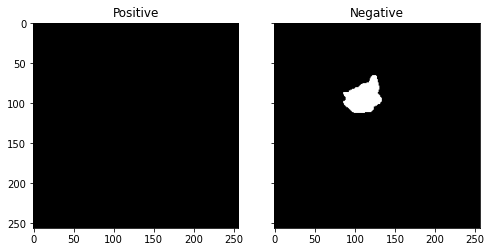

In [ ]:
fig = plt.figure(figsize = (8, 8))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 2), axes_pad = 0.5)

grid[0].imshow(cv2.imread(masks.iloc[1]['path']))
grid[0].set_title('Positive')

grid[1].imshow(cv2.imread(masks.iloc[2]['path']))
grid[1].set_title('Negative');

The negative masks have all numbers equal to 0. Positive masks have area with numbers > 0

In [ ]:
def set_diagnosis(path):
    if np.max(cv2.imread(path)) > 0:
        return 1
    return 0

data = pd.DataFrame({
    'patient': images['folder'].values,
    'image_path': images['path'].values,
    'mask': masks['path'].values
})
data['diagnosis'] = data['mask'].apply(lambda mask: set_diagnosis(mask))
data.head()

,patient,image_path,mask,diagnosis
0,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
1,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
2,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
3,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
4,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


# Analysis

0.3494527869686943


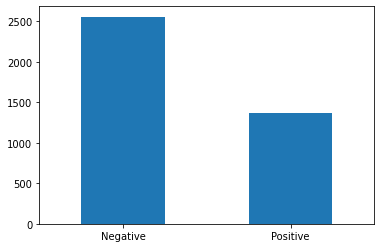

In [ ]:
ax = data.diagnosis.value_counts().plot.bar();
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0);
print(data.diagnosis.value_counts()[1] / data.diagnosis.value_counts().sum())

In [ ]:
positive_samples = data[data['diagnosis'] == 1].sample(5)['image_path'].sort_values().values
negative_samples = data[data['diagnosis'] == 0].sample(5)['image_path'].values
positive_masks = data.loc[data['image_path'].isin(positive_samples)]['mask'].sort_values().values

for i, (pos, neg, mask) in enumerate(zip(positive_samples, negative_samples, positive_masks)):
    pos = cv2.resize(cv2.imread(pos), (IMAGE_SIZE, IMAGE_SIZE))
    neg = cv2.resize(cv2.imread(neg), (IMAGE_SIZE, IMAGE_SIZE))
    mask = cv2.resize(cv2.imread(mask), (IMAGE_SIZE, IMAGE_SIZE))

    positive_samples[i] = pos
    negative_samples[i] = neg
    positive_masks[i] = mask

positive_samples = np.vstack(positive_samples)
negative_samples = np.vstack(negative_samples)
positive_masks = np.vstack(positive_masks)

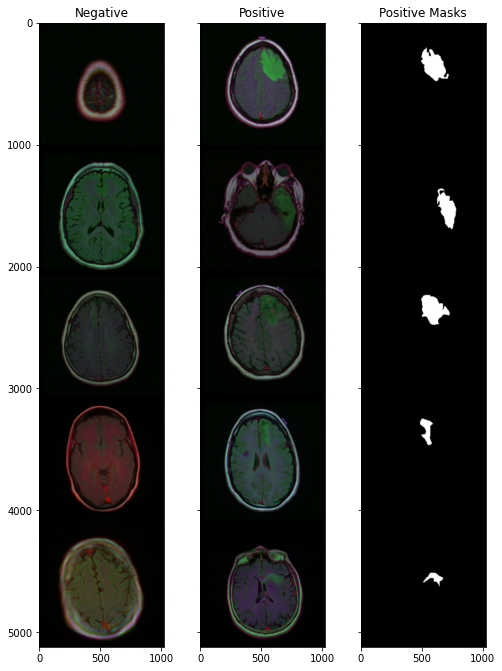

In [ ]:
fig = plt.figure(figsize = (8, 14))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 3), axes_pad = 0.5)

grid[0].imshow(negative_samples)
grid[0].set_title('Negative')

grid[1].imshow(positive_samples)
grid[1].set_title('Positive');

grid[2].imshow(positive_masks)
grid[2].set_title('Positive Masks');

# Dataset class and Dataloader class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensor
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_4.tif
TCGA_HT_7855_19951020_4.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9.tif
TCGA_HT_8018_19970411_9.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_32.tif
TCGA_FG_6690_20020226_32.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_13.tif
TCGA_FG_A60K_20040224_13.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41.tif
TCGA_FG_7643_20021104_41.tif
Label = 0
Image Shape: (256, 256, 3)



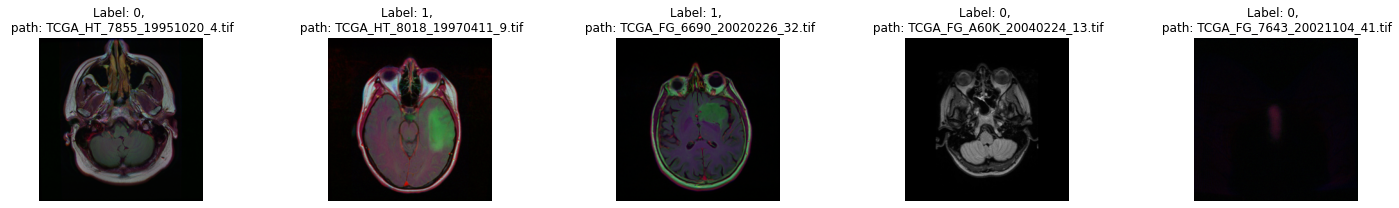

In [ ]:
class MRI_dataset(Dataset):
    def __init__(self, data, folder, transform = None):
        self.data = data
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data['image_path'].iloc[index]
        mask_path = self.data['mask'].iloc[index]

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)

        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']

        diagnosis = data['diagnosis'][index]
        return image_path, image, mask, diagnosis

def visualize_samples(dataset, indices, count = 5):
    # visualize random samples
    plt.figure(figsize=(count*5,3))
    display_indices = indices[:count]
       
    for i, index in enumerate(display_indices):    
        image_path, image, mask, diagnosis = dataset[index]
        print(image_path)
        path = os.path.split(image_path)[-1]
        print(path)
        print(f"Label = {data[data['image_path'] == image_path]['diagnosis'].to_string().split()[-1]}")
        print(f'Image Shape: {np.array(image).shape}')
        print()
        plt.subplot(1,count,i+1)
        plt.title(f"Label: {diagnosis}, \n path: {path}")
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')

orig_dataset = MRI_dataset(data, PATH)
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace = False)

visualize_samples(orig_dataset, indices)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_4.tif
TCGA_HT_7855_19951020_4.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9.tif
TCGA_HT_8018_19970411_9.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_32.tif
TCGA_FG_6690_20020226_32.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_13.tif
TCGA_FG_A60K_20040224_13.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41.tif
TCGA_FG_7643_20021104_41.tif
Label = 0
Image Shape: (256, 256, 3)



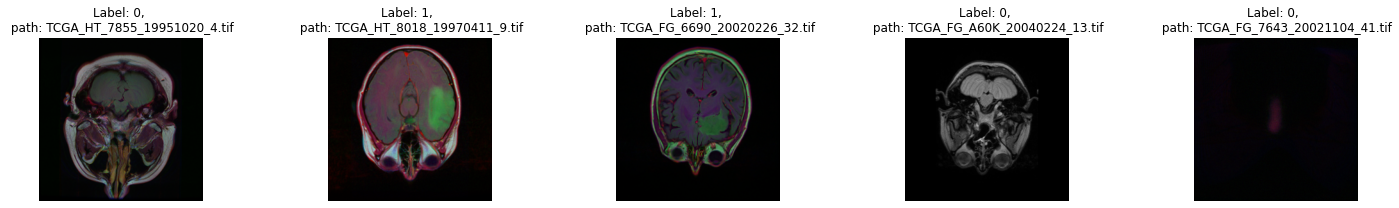

In [ ]:
## Let's make sure transforms work!
## Samples with flip - a lot should be flipped!
dataset = MRI_dataset(data, PATH, transform = A.VerticalFlip(1))
visualize_samples(dataset, indices)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 11)

PATCH_SIZE = 256

transform = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  
    A.Normalize(p=1.0),
    ToTensor(),
])

train_dataset = MRI_dataset(train_data, PATH, transform = transform)

test_dataset = MRI_dataset(test_data, PATH, transform = transform)

In [ ]:
len(train_dataset), len(test_dataset)

(3143, 786)

In [ ]:
batch_size = 16

data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(11)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = train_sampler) 
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

In [ ]:
## Let's use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# UNet

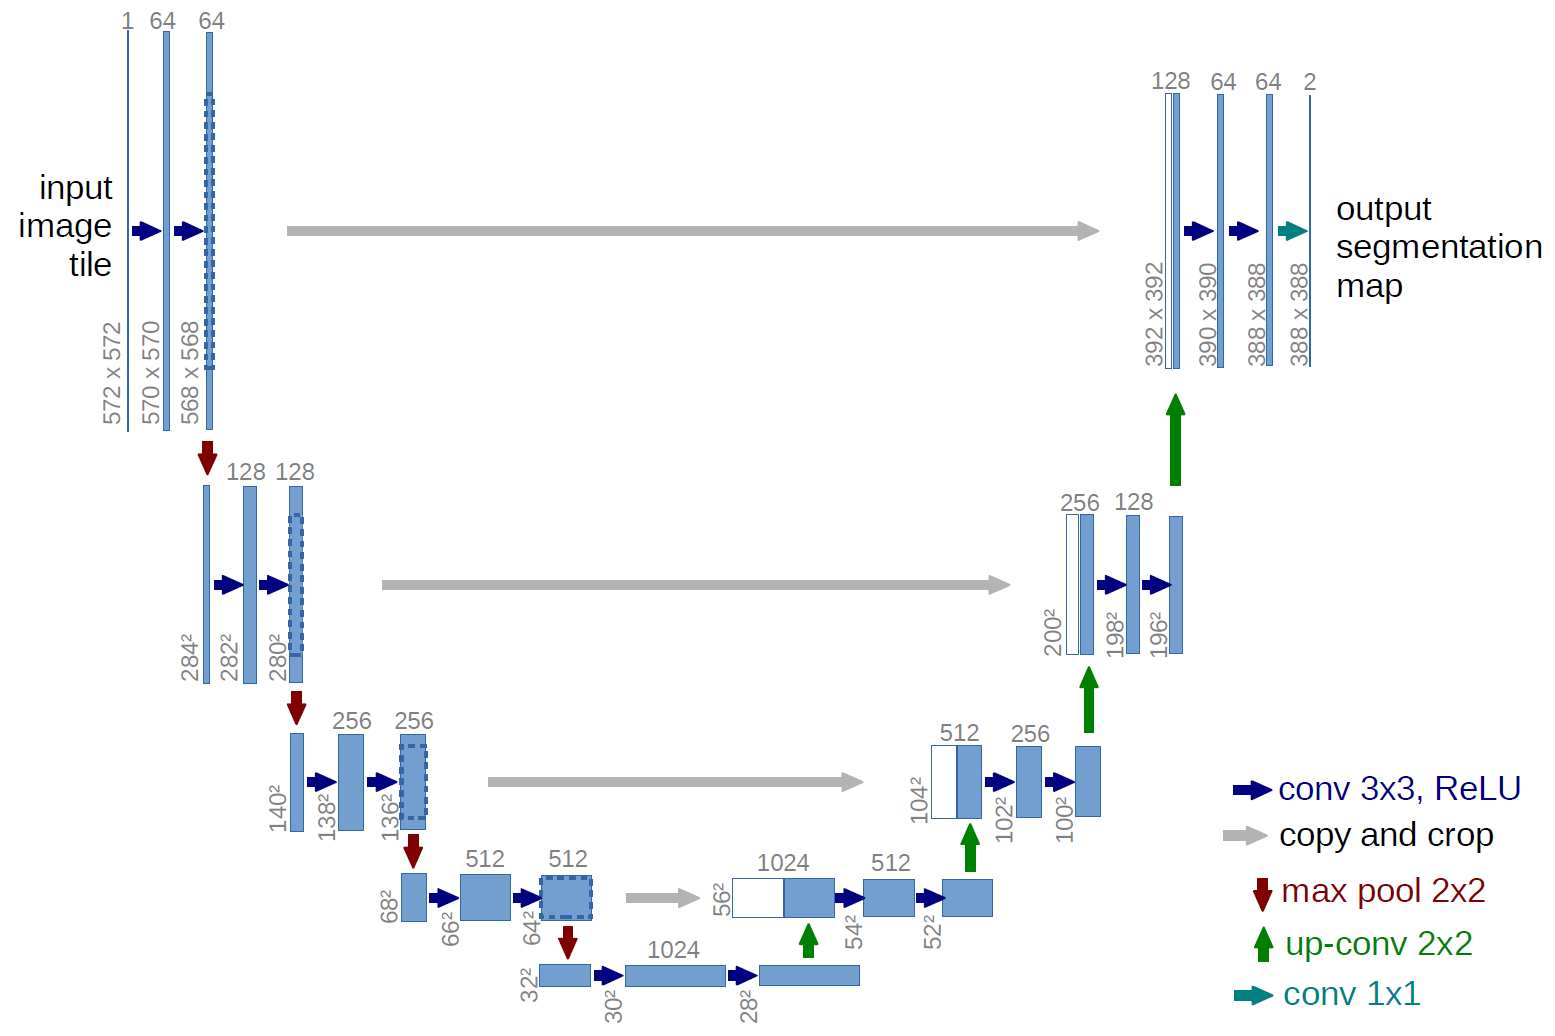

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True)
    )

class UNet(nn.Module):
    def __init__(self, n_classes = 1):
        super().__init__()

        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)

        self.conv_up1 = double_conv(1024 + 512, 512)
        self.conv_up2 = double_conv(512 + 256, 256)
        self.conv_up3 = double_conv(256 + 128, 128)
        self.conv_up4 = double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size = 1)

    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.conv_down4(x)
        x = self.maxpool(conv4)

        x = self.conv_down5(x)

        x = self.upsample(x)
        x = torch.cat([x, conv4], dim = 1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim = 1)
        x = self.conv_up2(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim = 1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim = 1)
        x = self.conv_up4(x)

        x = self.last_conv(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
unet = UNet(n_classes = 1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [102]:
def dice_coef_metric(inputs, target, smooth = 1):
    # intersection = (target * inputs).sum()
    # union = target.sum() + inputs.sum()
    # if target.sum() == 0 and inputs.sum() == 0:
    #     return 1.0

    # return (2 * intersection + smooth) / (union + smooth)
    intersection = (inputs * target).sum()

    return (2. * intersection + smooth) / (inputs.sum() + target.sum() + smooth)

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9655172413793103

In [97]:
def dice_coef_loss(inputs, target):

    # np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode

        losses = []       ## for each epoch count average
        train_dice = []

        for i_step, (_, x, y, _) in enumerate(train_loader):
                
            optimizer.zero_grad()
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)

            prediction_cpu = np.copy(prediction.data.cpu().numpy())
            prediction_cpu[np.nonzero(prediction_cpu < 0.5)] = 0.0
            prediction_cpu[np.nonzero(prediction_cpu >= 0.5)] = 1.0

            # train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss_value = loss(prediction, y_gpu)
            
            losses.append(loss_value.item())
            train_dice.append(dice_coef_metric(prediction_cpu, y.data.cpu().numpy()))

            loss_value.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()

        val_mean_dice = compute_dice(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_dice).mean())
        val_history.append(val_mean_dice)

        print(f'Epoch: {epoch}, Loss: {np.array(losses).mean()}, Train DICE: {np.array(train_dice).mean()}, Val DICE: {val_mean_dice}')
        
    return loss_history, train_history, val_history

def compute_dice(model, loader, threshold = 0.5):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    val_loss = 0
    
    with torch.no_grad():

        for i_step, (_, x, y, _) in enumerate(loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)
            
            # outputs = model(data)
            # print("val_output:", outputs.shape)

            prediction_cpu = np.copy(prediction.data.cpu().numpy())
            prediction_cpu[np.nonzero(prediction_cpu < threshold)] = 0.0
            prediction_cpu[np.nonzero(prediction_cpu >= threshold)] = 1.0

            picture_loss = dice_coef_metric(prediction_cpu, y.data.cpu().numpy())
            val_loss += picture_loss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return val_loss / i_step

In [ ]:
from torch import optim

unet_optimizer = optim.Adamax(unet.parameters(), lr = 1e-4)

In [ ]:
%%time
EPOCHS = 60
scheduler = optim.lr_scheduler.CosineAnnealingLR(unet_optimizer, T_max = 50)
loss_history, train_history, val_history = train_model(unet, train_loader, val_loader, bce_dice_loss, unet_optimizer, EPOCHS, scheduler)                                                                                                 
# loss, train, val = train_model("UNet", unet, train_loader, val_loader, bce_dice_loss, unet_optimizer, False, num_ep)

Epoch: 0, Loss: 1.0516345663161217, Train DICE: 0.0, Val DICE: 0.02564102564102564
Epoch: 1, Loss: 0.7461538303501999, Train DICE: 0.3011408317714916, Val DICE: 0.46767594699596043
Epoch: 2, Loss: 0.563821942934507, Train DICE: 0.5112346102838159, Val DICE: 0.4645143650935202
Epoch: 3, Loss: 0.5159917453044578, Train DICE: 0.546788124374135, Val DICE: 0.5236789611699268
Epoch: 4, Loss: 0.4819880639073215, Train DICE: 0.5756921475846698, Val DICE: 0.5671170668908581
Epoch: 5, Loss: 0.467155690528924, Train DICE: 0.5856316214617121, Val DICE: 0.5901931972702902
Epoch: 6, Loss: 0.422145041483867, Train DICE: 0.628101647533468, Val DICE: 0.571945933373641
Epoch: 7, Loss: 0.3907559847907175, Train DICE: 0.6559624001062371, Val DICE: 0.6375045394360991
Epoch: 8, Loss: 0.3792889127625695, Train DICE: 0.6652938112504924, Val DICE: 0.6388179613786279
Epoch: 9, Loss: 0.38349042710246917, Train DICE: 0.660334159634135, Val DICE: 0.6746463233357402
Epoch: 10, Loss: 0.3587745974146867, Train DICE: 

In [ ]:
test_dice = compute_dice(unet, test_loader)
print(f'DICE = {np.round(test_dice, 2)}')

DICE = 0.79


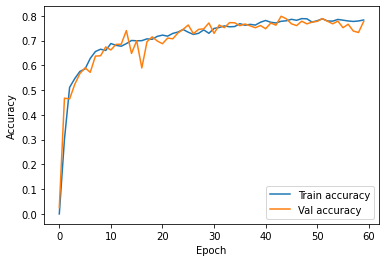

In [35]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

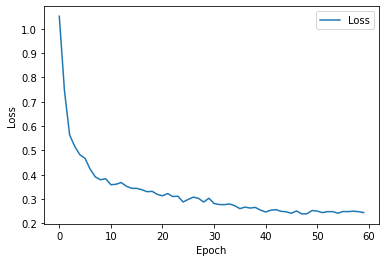

In [36]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [44]:
transform
image = cv2.imread(test_sample[1])

mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

image = (image - mean) / std

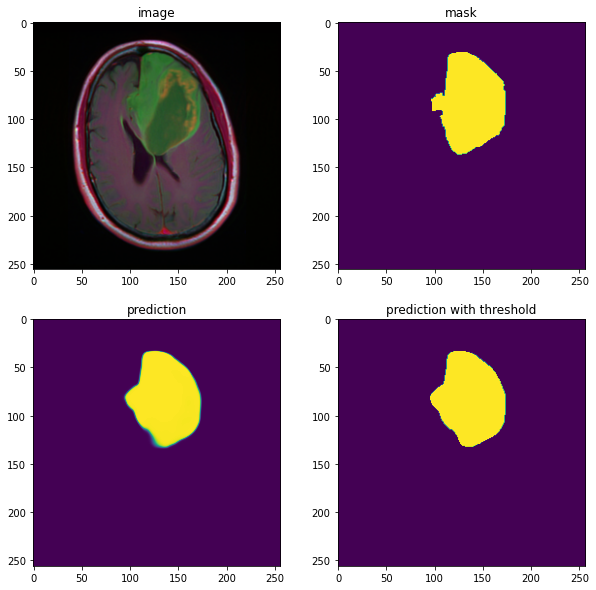

In [140]:
# image
test_sample = test_data[test_data["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (PATCH_SIZE, PATCH_SIZE))

#mask
mask = cv2.resize(cv2.imread(test_sample[2], 0), (PATCH_SIZE, PATCH_SIZE))
mask = torch.tensor(mask.astype(np.float32) / 255.).numpy()

# pred
mean = 0.456
std = 0.224

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = (pred - mean) / std
pred = unet(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.5)] = 0.0
pred_t[np.nonzero(pred_t >= 0.5)] = 1.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [146]:
test_dice = dice_coef_metric(pred, np.array(mask))
print(f'DICE = {np.round(test_dice, 2)}')

DICE = 0.94


In [123]:
# torch.save(unet.state_dict(), 'unet_60epochs.pt')

### load model

In [120]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [147]:
PATH = '/content/gdrive/Shareddrives/DigitalHome I UnlimitedDisc 3/Alex/ML_important_files/torch_models/unet_60epochs.pt'


loaded_model = UNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.to(device)

test_dice = compute_dice(loaded_model, test_loader)
print(f'DICE = {np.round(test_dice, 2)}')

DICE = 0.79


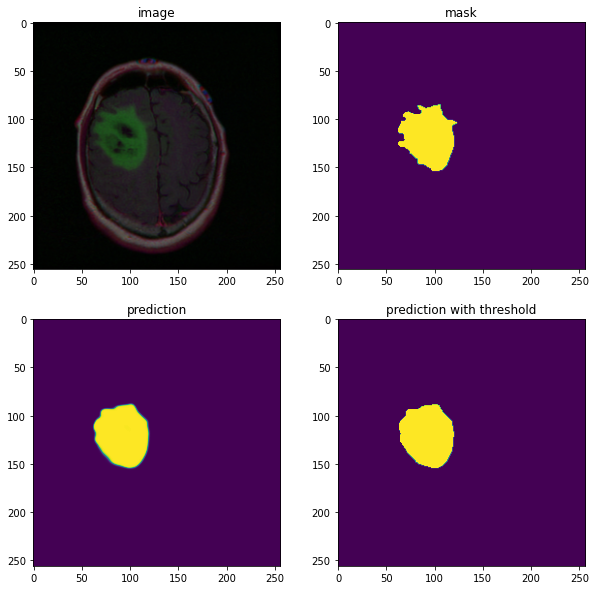

In [144]:
# image
test_sample = test_data[test_data["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (PATCH_SIZE, PATCH_SIZE))

#mask
mask = cv2.resize(cv2.imread(test_sample[2], 0), (PATCH_SIZE, PATCH_SIZE))
mask = torch.tensor(mask.astype(np.float32) / 255.).numpy()

# pred
mean = 0.456
std = 0.224

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = (pred - mean) / std
pred = loaded_model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.5)] = 0.0
pred_t[np.nonzero(pred_t >= 0.5)] = 255
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()